In [1]:
# all necessary includes

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

import os
import nltk
# nltk.download('stopwords')
from string import punctuation
from pymystem3 import Mystem

In [2]:
# additional functions
import re
mystem = Mystem()
garbage_words = stopwords.words('english') + stopwords.words('russian')


# will split dataframe into samples with same proportion of each document class
def SplitTrainSample(dataframe, fraction=0.7):
    '''
    1) to form arrays for each document class
    2) to split each class by np.split
    3) to shuffle rows in resulting dataframe1 and dataframe2
    '''
    types = set(dataframe['target'])
    print(types)
    dataframes = [dataframe[dataframe['target'] == doc_type] for doc_type in types]
    splited = [np.split(df.sample(frac=1), [int(fraction * len(df))]) for df in dataframes]
    test = [df[0] for df in splited]
    train = [df[1] for df in splited]
    return pd.concat(train).sample(frac=1), pd.concat(test).sample(frac=1)


def CreateVectorizer(ngram_range, max_features):
    return CountVectorizer(analyzer = "word",
                           #min_df=5,
                           #max_df=0.7,
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           ngram_range = ngram_range,
                           max_features = max_features
                         )



def TrainRandomForestClassifier(dataframe, n_estimators=300):
    ngram_range = (1, 3)
    max_features = 50000

    vectorizer = CreateVectorizer(ngram_range, max_features)
    X_train, Y_train = dataframe['X'], dataframe['target']
    
    X_train = vectorizer.fit_transform(X_train)
    #print(X_train.shape)
    #print(type(X_train))
    # X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)
    model = model.fit(X_train, Y_train)
    return vectorizer, model


def CalculateAccuracy(model, vectorizer, ds, confidence_level):
    ds['predict'] = model.predict(vectorizer.transform(ds['X']))
    ds['confidence'] = np.transpose(np.amax(model.predict_proba(vectorizer.transform(ds['X'])), axis=1))

    precision = round(100 * len(ds[(ds['confidence'] >= confidence_level) & (ds['target'] == ds['predict'])]) / len(ds), 2)
    to_validate = round(100 * len(ds[(ds['confidence'] < confidence_level)]) / len(ds), 2)
    return precision, to_validate, confidence_level


def BuildDataFrame(cur_folder, doc_types, file_names, doc_texts, name=''):
    files = os.listdir()
    cur_name = name[:]
    if len(cur_name) != 0:
        cur_name += '-'
    cur_name += cur_folder
    if 'text_layer' in files:
        files.remove('text_layer')
        print('in', cur_name)
        
    folders = [file for file in files if '.' not in file]
    
    for folder in folders:
        os.chdir(folder)
        BuildDataFrame(folder, doc_types, file_names, doc_texts, cur_name)
        os.chdir('..')
    if len(folders) == 0:
        for file in files:
            text_layer = ''
            if 'text_layer' in os.listdir():
                try:
                    with open('./text_layer/' + file.split('.')[0] + '.txt') as f:
                        text_layer = f.read()
                except:
                    NOT_FOUND.append((file, cur_name))
            if len(text_layer) > 0:
                doc_texts.append(text_layer)
                doc_types.append(cur_name)
                file_names.append(file)
        

In [3]:
# build dataframe
NOT_FOUND = []
doc_types, file_names, doc_texts = [], [], []

dataset_path = 'for training'
os.chdir(dataset_path)
BuildDataFrame('', doc_types, file_names, doc_texts)
os.chdir('..')
df = pd.DataFrame({'file_name': file_names, 'doc_type': doc_types, 'doc_text' : doc_texts})
# print(df)

in ad-error
in ad-invoice-first
in ad-invoice-multi
in ad-statement-first
in ad-statement-multi
in ad-upd-first
in ad-upd-multi
in ad-waybill-first
in ad-waybill-multi
in rfq-AOG
in rfq-CRITICAL
in rfq-Routine
in rfq-Spam
in sec-error
in sec-Изменение контроля
in sec-Кросс-дефолт
in sec-Обозначение прав дочерних компаний
in sec-Оговорки о коллективных действиях
in sec-Ограничение деятельности
in sec-Ограничение задолженности
in sec-Ограничение задолженности дочерних компаний
in sec-Ограничение по инвестициям
in sec-Ограничение по наслоению долговых обязательств по рангам
in sec-Ограничение по платежам
in sec-Ограничение по платежам в отношении дочерних компаний
in sec-Ограничение по предоставлению залога
in sec-Ограничение по продаже активов
in sec-Ограничение по продаже активов с обратной арендой
in sec-Ограничение по слиянию
in sec-Ограничение по транзакциям с аффилированными лицами
in sec-Случаи дефолта
in sec-Триггер рейтингов
in sec-Условие приостановки действия ковенантов
in sec-

In [4]:
# part for checking files that weren't found
ext = [x[0].split('.')[-1] for x in NOT_FOUND]
print(set(ext))
formated_not_found = ['file {} at {} not found'.format(x[0], x[1]) for x in NOT_FOUND if '' in x[0].split('.')[-1].lower()]
print(len(formated_not_found))
print('\n'.join(formated_not_found))

{'jpg', 'PDF', 'JPEG', 'pdf', 'msg'}
49
file 06014769-9ae4-458d-a7cb-8ade56355dd6.pdf at ad-error not found
file 1012b487-da5b-43b3-91b5-1862e8b07c5a.pdf at ad-error not found
file 10f6b3f1-bcaa-49c6-af90-4493d6d50cbd.pdf at ad-error not found
file 19596038-1690-4aa0-84aa-162381f70581.pdf at ad-error not found
file 1e9ba652-ca81-4eec-9208-d0dfad11469b.pdf at ad-error not found
file 1f6f9a23-d9c4-4ed8-be3b-89afd4c77568.pdf at ad-error not found
file 25cbeedc-2612-4784-86de-0e139945707b.pdf at ad-error not found
file 29dcc2e1-9a68-49c1-9d43-741cf491d5dc.pdf at ad-error not found
file 2a4d3482-25d4-403b-9a0d-4b41841d44b3.pdf at ad-error not found
file 369310e4-850d-46bb-a756-151af523810a.pdf at ad-error not found
file 41aebe14-3183-46a1-b4fd-3a1513b787c7.pdf at ad-error not found
file 4889bca2-01e1-4c31-bacb-0632f36878c8.pdf at ad-error not found
file 4a753c6d-80d7-4cc9-b0e8-0192b82f0377.PDF at ad-error not found
file 51a0488a-44cd-4956-b749-998de144527b.pdf at ad-error not found
file 544

In [5]:
def ClearText(text, garbage_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[().,:-]', '', text).replace('\n', ' ')
    # text = ' '.join([word for word in text.lower().split() if word not in garbage_words and word.strip() not in punctuation])
    # tokens = mystem.lemmatize(text.lower())
    tokens = text.lower().split()
    tokens = [token for token in tokens if token not in garbage_words and token != ' ' and token.strip() not in punctuation]
    #tokens = tokens.replace('\n', '')
    text = ' '.join(tokens)
    
    return text

In [7]:
for i in range(len(df['doc_text'])):
    df['doc_text'][i] = ClearText(df['doc_text'][i], garbage_words)

df = df.rename(columns={'doc_type' : 'target', 'doc_text' : 'X'})

In [8]:
types_list = list(set(df['target']))
types_fra = [len(df[df['target']  == tp]) / len(df) for tp in types_list]
stat = pd.DataFrame({'target': types_list, 'percentage' : types_fra}).sort_values('percentage')
stat

,target,percentage
10,sec-Ограничение по инвестициям,0.000041
29,sec-Ограничение по наслоению долговых обязател...,0.000246
9,sec-Ограничение по платежам в отношении дочерн...,0.000451
14,sec-Условие приостановки действия ковенантов,0.000451
20,sec-Ограничение по платежам,0.000492
19,sec-Ограничение задолженности дочерних компаний,0.000534
12,sec-Обозначение прав дочерних компаний,0.000534
24,sec-Ограничение по продаже активов с обратной ...,0.000575
3,sec-Ограничение задолженности,0.000575
23,sec-Ограничение по продаже активов,0.000575


In [9]:
# split into training (0.6 of dataframe) validation (0.2 of dataframe) and test (0.2 of dataframe)

train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
# train, test = SplitTrainSample(df, fraction=0.7)

In [10]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=90, stop=170, num=9)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=15, stop=50, num=8)] + [None]
min_samples_split = [int(x) for x in np.linspace(start=20, stop=50, num=8)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=7, num=3)]
bootstrap = [True, False]

param_dist = {
    'clf__n_estimators' : n_estimators,
    'clf__max_features' : max_features,
    'clf__max_depth' : max_depth,
    'clf__min_samples_split' : min_samples_split,
    'clf__min_samples_leaf' : min_samples_leaf,
    'clf__bootstrap' : bootstrap,
    'vctr__min_df' : [0.1, 1, 0.05, 0.2],
    'vctr__max_df' : [1, 0.9, 0.7],
    'vctr__max_features' : [10000,  30000, 50000]
}
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('vctr', CountVectorizer(ngram_range=(1, 3), max_features=50000)),
    ('clf', RandomForestClassifier())])
print(param_dist)
print(pipe)

{'clf__n_estimators': [90, 100, 110, 120, 130, 140, 150, 160, 170], 'clf__max_features': ['log2', 'sqrt'], 'clf__max_depth': [15, 20, 25, 30, 35, 40, 45, 50, None], 'clf__min_samples_split': [20, 24, 28, 32, 37, 41, 45, 50], 'clf__min_samples_leaf': [1, 4, 7], 'clf__bootstrap': [True, False], 'vctr__min_df': [0.1, 1, 0.05, 0.2], 'vctr__max_df': [1, 0.9, 0.7], 'vctr__max_features': [10000, 30000, 50000]}
Pipeline(steps=[('vctr',
                 CountVectorizer(max_features=50000, ngram_range=(1, 3))),
                ('clf', RandomForestClassifier())])


In [11]:
train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
#train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
#vectorizer = CreateVectorizer((1, 3), 50000)
#X_train = vectorizer.fit_transform(X_train)

In [12]:
rf = RandomForestClassifier()
rs = RandomizedSearchCV(pipe,
                        param_dist,
                        n_iter=70,
                        cv=3,
                        verbose=3,
                        n_jobs=1,
                        random_state=0,
                        scoring='accuracy')
rs.fit(X_train, Y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=37, clf__n_estimators=90, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=0.1;, score=0.862 total time=  43.5s
[CV 2/3] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=37, clf__n_estimators=90, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=0.1;, score=0.860 total time=  43.5s
[CV 3/3] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=37, clf__n_estimators=90, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=0.1;, score=0.857 total time=  44.4s
[CV 1/3] END clf__bootstrap=False, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=90, vctr__max_df=0.7, vctr__max_features=50000, vctr__min_df=0.2;, score=0.843 total time=  33.3s
[CV 2/3] END clf__b

[CV 2/3] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=90, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=1;, score=0.812 total time=  30.7s
[CV 3/3] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=90, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=1;, score=0.814 total time=  30.5s
[CV 1/3] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=130, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=1;, score=0.811 total time=  31.3s
[CV 2/3] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=130, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=1;, score=0.804 total time=  31.6s
[CV 3/3] END clf__bootst

[CV 3/3] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=log2, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__max_features=30000, vctr__min_df=1;, score=0.805 total time=  30.8s
[CV 1/3] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=32, clf__n_estimators=140, vctr__max_df=0.7, vctr__max_features=50000, vctr__min_df=0.2;, score=0.849 total time=  42.7s
[CV 2/3] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=32, clf__n_estimators=140, vctr__max_df=0.7, vctr__max_features=50000, vctr__min_df=0.2;, score=0.845 total time=  42.9s
[CV 3/3] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=32, clf__n_estimators=140, vctr__max_df=0.7, vctr__max_features=50000, vctr__min_df=0.2;, score=0.845 total time=  43.3s
[CV 1/3] END

[CV 1/3] END clf__bootstrap=True, clf__max_depth=25, clf__max_features=sqrt, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=140, vctr__max_df=1, vctr__max_features=50000, vctr__min_df=0.05;, score=nan total time=  12.1s
[CV 2/3] END clf__bootstrap=True, clf__max_depth=25, clf__max_features=sqrt, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=140, vctr__max_df=1, vctr__max_features=50000, vctr__min_df=0.05;, score=nan total time=  12.4s
[CV 3/3] END clf__bootstrap=True, clf__max_depth=25, clf__max_features=sqrt, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=140, vctr__max_df=1, vctr__max_features=50000, vctr__min_df=0.05;, score=nan total time=  12.3s
[CV 1/3] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__max_features=50000, vctr__min_df=0.2;, score=0.810 total time=  34.4s
[CV 2/3] END clf__bootstr

[CV 2/3] END clf__bootstrap=False, clf__max_depth=25, clf__max_features=sqrt, clf__min_samples_leaf=4, clf__min_samples_split=37, clf__n_estimators=130, vctr__max_df=1, vctr__max_features=10000, vctr__min_df=0.2;, score=nan total time=  12.1s
[CV 3/3] END clf__bootstrap=False, clf__max_depth=25, clf__max_features=sqrt, clf__min_samples_leaf=4, clf__min_samples_split=37, clf__n_estimators=130, vctr__max_df=1, vctr__max_features=10000, vctr__min_df=0.2;, score=nan total time=  12.0s
[CV 1/3] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=1;, score=0.816 total time=  31.6s
[CV 2/3] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__max_features=30000, vctr__min_df=1;, score=0.815 total time=  31.0s
[CV 3/3] END clf__bo

[CV 3/3] END clf__bootstrap=True, clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=37, clf__n_estimators=160, vctr__max_df=0.7, vctr__max_features=50000, vctr__min_df=0.2;, score=0.839 total time=  39.1s
[CV 1/3] END clf__bootstrap=False, clf__max_depth=25, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=100, vctr__max_df=1, vctr__max_features=50000, vctr__min_df=0.2;, score=nan total time=  11.9s
[CV 2/3] END clf__bootstrap=False, clf__max_depth=25, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=100, vctr__max_df=1, vctr__max_features=50000, vctr__min_df=0.2;, score=nan total time=  12.0s
[CV 3/3] END clf__bootstrap=False, clf__max_depth=25, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=100, vctr__max_df=1, vctr__max_features=50000, vctr__min_df=0.2;, score=nan total time=  12.4s
[CV 1/3] END clf__bootstr

[CV 1/3] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=24, clf__n_estimators=110, vctr__max_df=0.9, vctr__max_features=50000, vctr__min_df=0.05;, score=0.871 total time=  46.8s
[CV 2/3] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=24, clf__n_estimators=110, vctr__max_df=0.9, vctr__max_features=50000, vctr__min_df=0.05;, score=0.873 total time=  46.0s
[CV 3/3] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=24, clf__n_estimators=110, vctr__max_df=0.9, vctr__max_features=50000, vctr__min_df=0.05;, score=0.869 total time=  45.6s
[CV 1/3] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=sqrt, clf__min_samples_leaf=7, clf__min_samples_split=20, clf__n_estimators=140, vctr__max_df=0.7, vctr__max_features=30000, vctr__min_df=0.1;, score=0.843 total time=  42.1s
[CV 2/3

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
54 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 355, in _fit
    **fit_param

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vctr',
                                              CountVectorizer(max_features=50000,
                                                              ngram_range=(1,
                                                                           3))),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=70, n_jobs=1,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__max_depth': [15, 20, 25, 30, 35,
                                                           40, 45, 50, None],
                                        'clf__max_features': ['log2', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 4, 7],
                                        'clf__min_samples_split': [20, 24, 28,
                                                

In [13]:
rs.best_params_

{'vctr__min_df': 1,
 'vctr__max_features': 30000,
 'vctr__max_df': 0.7,
 'clf__n_estimators': 130,
 'clf__min_samples_split': 20,
 'clf__min_samples_leaf': 1,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 45,
 'clf__bootstrap': True}

In [14]:
def GetResultsDataFrame(searcher):
    searcher_df = pd.DataFrame(searcher.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    searcher_df = searcher_df.drop([
        'mean_fit_time',
        'std_fit_time',
        'std_score_time',
        'mean_score_time',
        'params',
        'split0_test_score',
        'split1_test_score',
        'split2_test_score',
        'std_test_score'
    ], axis=1)
    return searcher_df

In [15]:
rs_df = GetResultsDataFrame(rs)
rs_df.head(10)

,param_vctr__min_df,param_vctr__max_features,param_vctr__max_df,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,param_clf__bootstrap,mean_test_score,rank_test_score
0,1,30000,0.7,130,20,1,sqrt,45,True,0.887754,1
1,1,10000,0.7,160,37,1,sqrt,35,True,0.884522,2
2,0.05,30000,0.7,130,45,1,sqrt,None,False,0.876366,3
3,0.05,50000,0.7,120,45,1,sqrt,35,False,0.875442,4
4,0.05,30000,0.7,100,50,1,sqrt,40,False,0.874775,5
5,0.05,50000,0.9,100,41,1,log2,None,False,0.871595,6
6,0.05,50000,0.9,110,24,1,log2,None,True,0.870877,7
7,1,30000,0.7,140,41,7,sqrt,45,True,0.869030,8
8,0.05,10000,0.9,130,50,1,log2,40,True,0.860822,9
9,0.1,30000,0.9,90,37,1,sqrt,50,True,0.859642,10


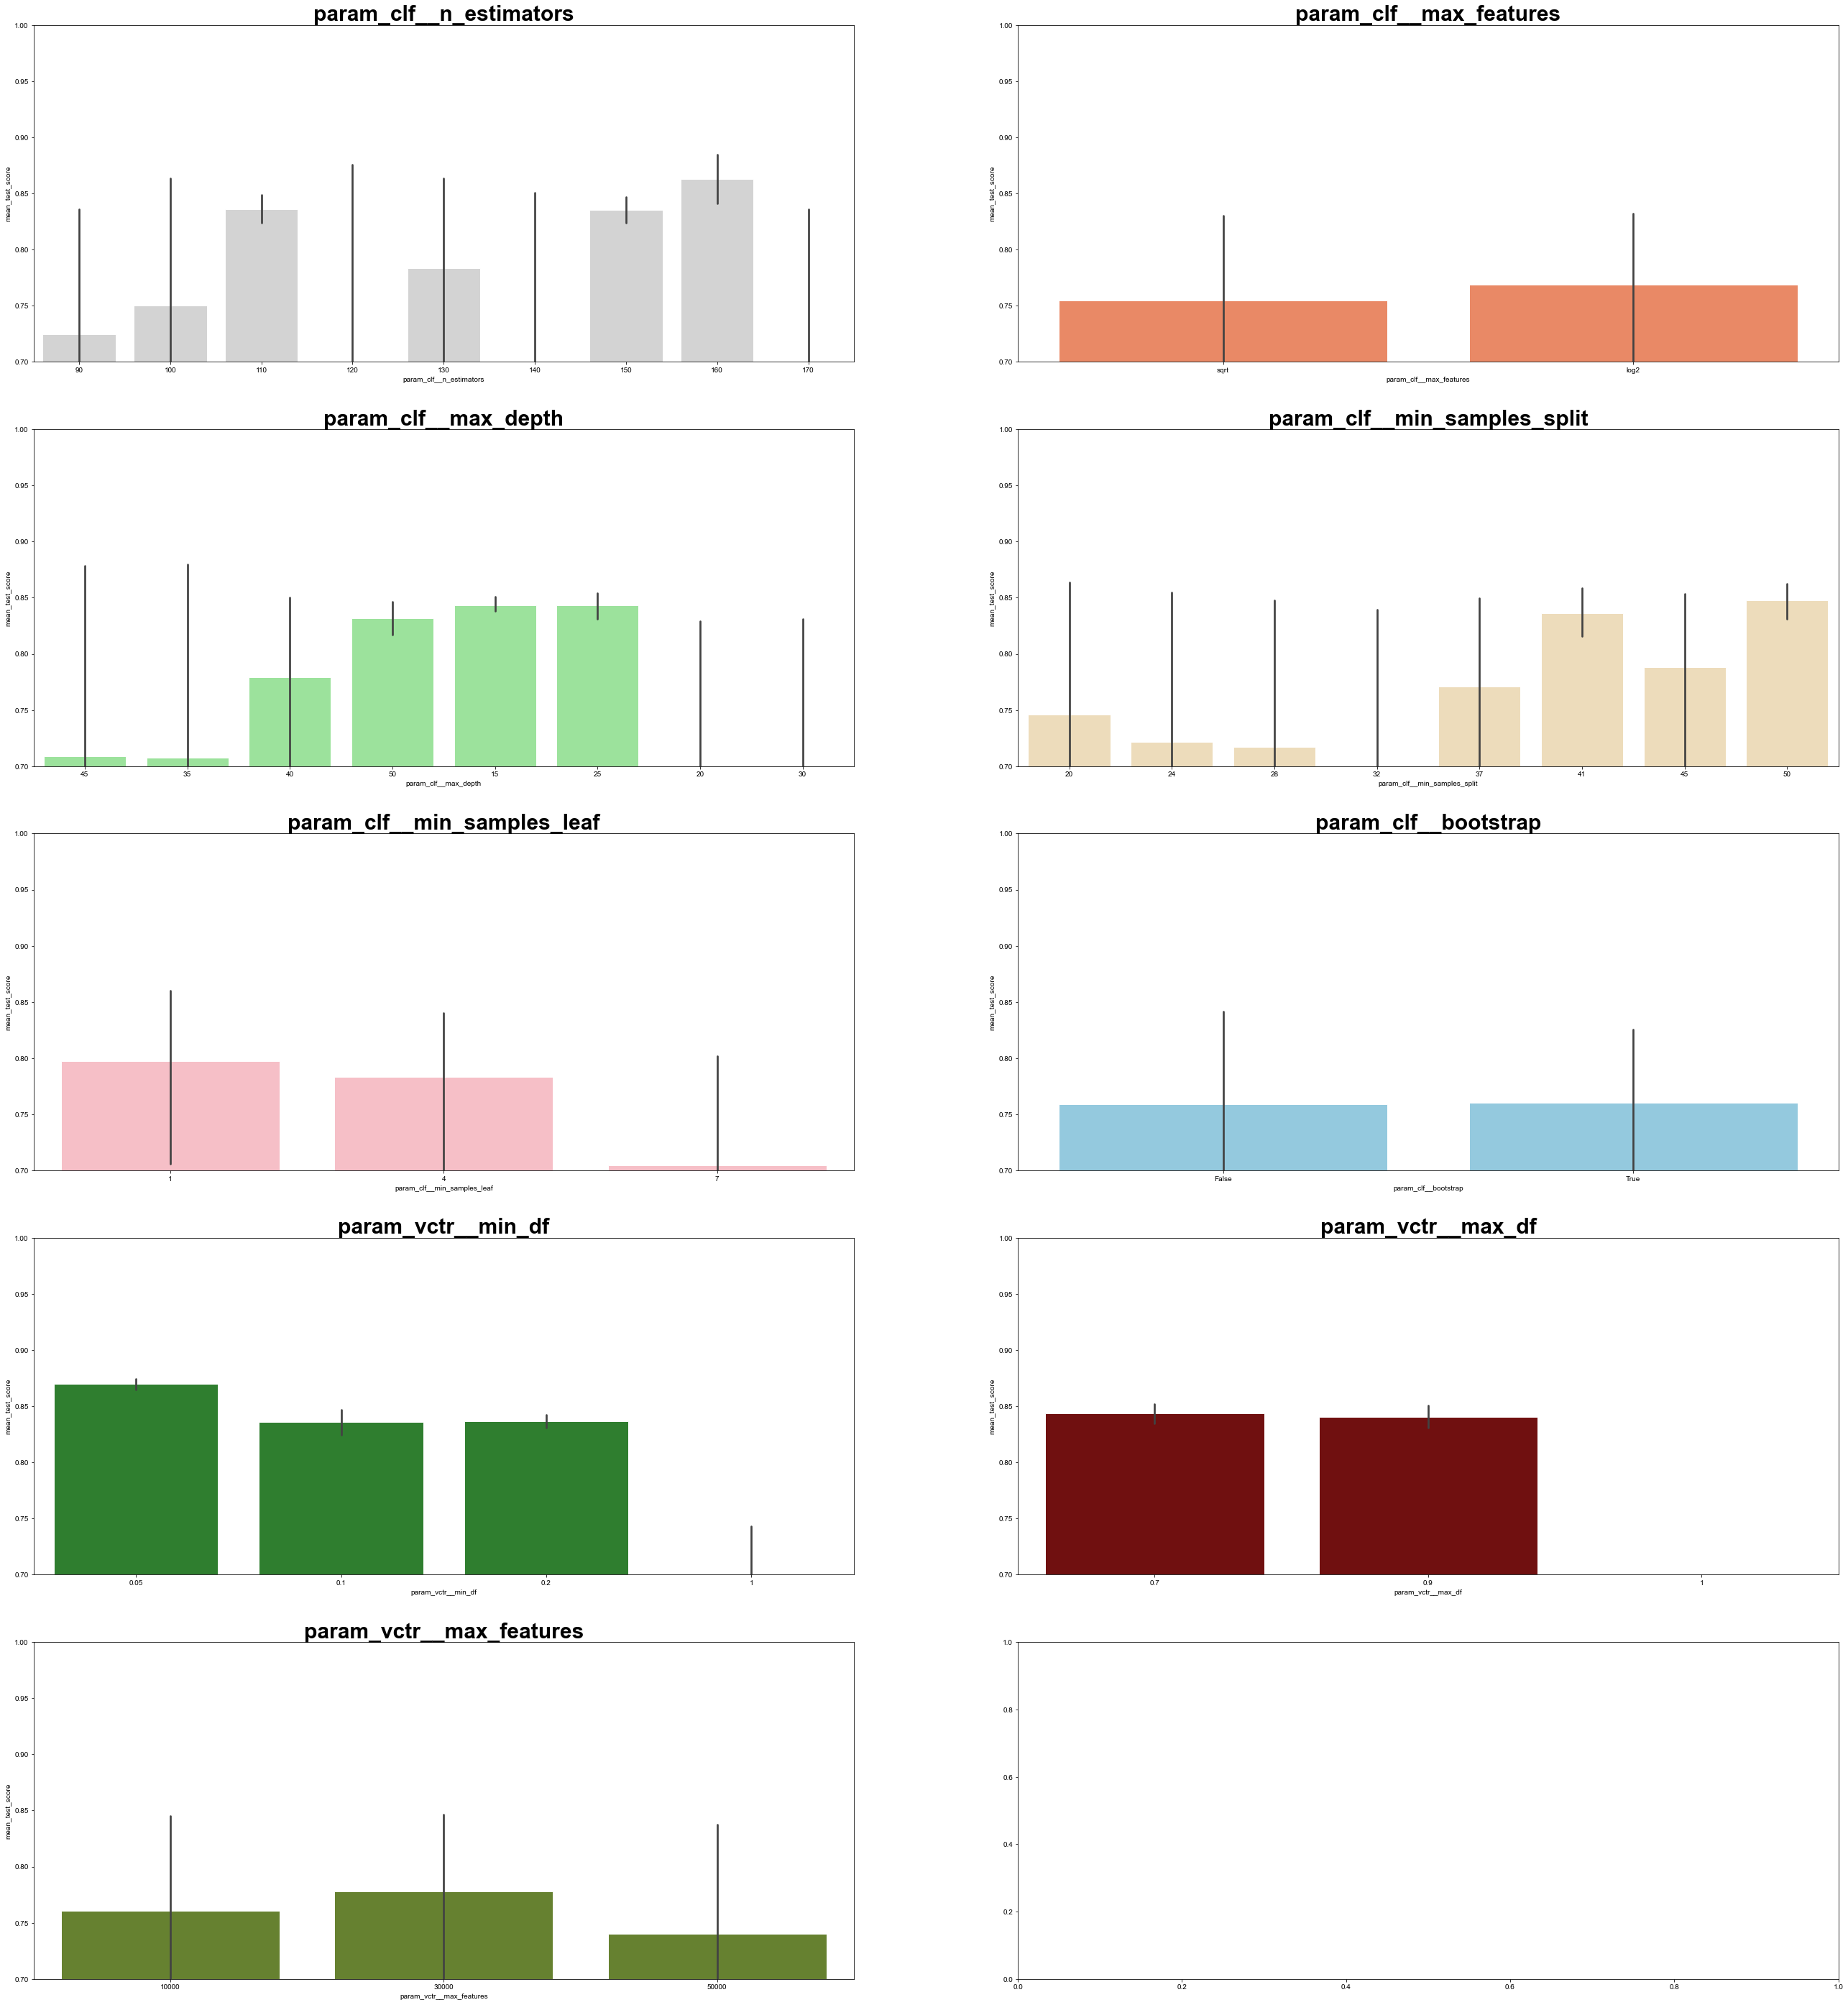

In [16]:
colors = ['lightgrey', 'coral', 'lightgreen', 'wheat', 'lightpink', 
          'skyblue', 'forestgreen', 'maroon', 'olivedrab']
params = ['param_' + x for x in list(param_dist.keys())]
ncols, nrows = 2, len(params) // 2 + len(params) % 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig.set_size_inches(45, 50)

for ind in range(len(params)):
    i = ind // ncols
    j = ind % ncols
    sns.barplot(x=params[ind], y='mean_test_score', data=rs_df, ax=axs[i, j], color=colors[ind])
    axs[i, j].set_ylim([.7, 1])
    axs[i, j].set_title(label=params[ind], size=30, weight='bold')

plt.show()

In [17]:
from sklearn.metrics import classification_report, accuracy_score
def ShowStatistics(model_, vectorizer_, to_show_model=True):
    if to_show_model:
        print('model:', model_)
        print('vectorizer:', vectorizer_)
    precision, to_validate, confidence_level = CalculateAccuracy(model_, vectorizer_, test.copy(), 0.8)
    prediction = model_.predict(vectorizer_.transform(test['X']))
    print('Rows in test set: {}'.format(len(test)))
    print('Statistics:')
    print('Precision = {}%; Ratio to validate = {}%; at confidence level = {}'.format(precision, to_validate, confidence_level))
    print('Mean accuracy: {}%'.format(round(100 * accuracy_score(test['target'], prediction), 2)))
    print(classification_report(test['target'], prediction))

In [18]:
rs.best_estimator_[0]

CountVectorizer(max_df=0.7, max_features=30000, ngram_range=(1, 3))

In [19]:
ShowStatistics(rs.best_estimator_[1], rs.best_estimator_[0])

model: RandomForestClassifier(max_depth=45, max_features='sqrt', min_samples_split=20,
                       n_estimators=130)
vectorizer: CountVectorizer(max_df=0.7, max_features=30000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 70.7%; Ratio to validate = 27.99%; at confidence level = 0.8
Mean accuracy: 89.39%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.96      0.93      0.95       872
                                            ad-invoice-multi       0.96      0.78      0.86       116
                                          ad-statement-first       0.98      0.99      0.98      1128
                                          ad-statement-multi       0.97      0.89      0.93       155
                                                ad-upd-first       0.90      0.97      0.93       704
                                                a

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def GetBestArgs(rs_df, param):
    a = rs_df.groupby(param).mean_test_score.mean().to_dict()
    srtd = [(a[key], key) for key in a.keys()]
    srtd.sort(key=lambda x: -x[0])
    srtd = [x[1] for x in srtd]
    return srtd

In [21]:
from sklearn.model_selection import GridSearchCV
best_n_estimators = GetBestArgs(rs_df, 'param_clf__n_estimators')[:3]
#best_max_features = GetBestArgs(rs_df, 'param_max_features')[:1]
best_max_depth = [None] + GetBestArgs(rs_df, 'param_clf__max_depth')[:1]
best_min_samples_split = GetBestArgs(rs_df, 'param_clf__min_samples_split')[:3]
best_min_samples_leaf = GetBestArgs(rs_df, 'param_clf__min_samples_leaf')[:3]
#best_bootstrap = [False, True]

best_min_df = GetBestArgs(rs_df, 'param_vctr__min_df')[:2]
best_max_df = GetBestArgs(rs_df, 'param_vctr__max_df')[:2]
param_grid = {
    'clf__n_estimators' : best_n_estimators,
    #'max_features' : best_max_features,
    'clf__max_depth' : best_max_depth,
    'clf__min_samples_split' : best_min_samples_split,
    'clf__min_samples_leaf' : best_min_samples_leaf,
    #'bootstrap' : best_bootstrap,
    'vctr__min_df' : best_min_df,
    'vctr__max_df' : best_max_df
}

pipe = Pipeline([
    ('vctr', CountVectorizer(ngram_range=(1, 3), max_features=50000)),
    ('clf', RandomForestClassifier())])
print(param_grid)
print(pipe)

{'clf__n_estimators': [160, 110, 150], 'clf__max_depth': [None, 25], 'clf__min_samples_split': [50, 41, 45], 'clf__min_samples_leaf': [1, 4, 7], 'vctr__min_df': [0.05, 0.2], 'vctr__max_df': [0.7, 0.9]}
Pipeline(steps=[('vctr',
                 CountVectorizer(max_features=50000, ngram_range=(1, 3))),
                ('clf', RandomForestClassifier())])


In [22]:
train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
#train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
#vectorizer = CreateVectorizer((1, 3), 50000)
#X_train = vectorizer.fit_transform(X_train)

In [23]:
rf = RandomForestClassifier()
gs = GridSearchCV(pipe, param_grid, cv=3, verbose=3, n_jobs=1)
gs.fit(X_train, Y_train)
print(gs.best_estimator_)
print(gs.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.872 total time=  53.3s
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.874 total time=  52.3s
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.869 total time=  52.3s
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.849 total time=  46.5s
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.851 total time=  46.2s
[CV 3/3] END clf__max_depth=None, clf__min_sample

[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.851 total time= 1.9min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.845 total time= 2.3min
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.873 total time=  47.0s
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.878 total time= 1.7min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.873 total time= 2.3min
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vct

[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.850 total time=  56.7s
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.848 total time= 1.5min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.845 total time= 2.1min
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.871 total time= 1.4min
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.877 total time= 1.7min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr

[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.860 total time=  46.4s
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.837 total time= 2.0min
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.839 total time= 1.8min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.835 total time=  38.8s
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.862 total time= 1.4min
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr

[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.865 total time= 1.9min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.861 total time=  44.9s
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.838 total time= 1.6min
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.841 total time= 2.1min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.834 total time=  53.9s
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr

[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.854 total time=  38.1s
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.855 total time=  54.0s
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.855 total time= 1.9min
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.835 total time= 1.6min
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.835 total time=  35.0s
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vct

[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.833 total time=  40.9s
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.853 total time= 1.2min
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.859 total time= 2.2min
[CV 3/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.852 total time= 1.3min
[CV 1/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.835 total time=  39.7s
[CV 2/3] END clf__max_depth=None, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vct

[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.849 total time= 1.5min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.843 total time= 2.3min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.869 total time= 1.1min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.871 total time= 1.6min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.866 total time= 2.6min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=50, clf__n_estimators=160, vctr__max_df=0.

[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.845 total time=  39.4s
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.851 total time= 1.4min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.843 total time= 2.1min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.869 total time= 1.1min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.872 total time= 1.0min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=41, clf__n_estimators=110, vctr__max_df=0.9

[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.866 total time= 1.6min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.847 total time=  46.9s
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.850 total time= 2.3min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.844 total time= 1.7min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.05;, score=0.868 total time=  49.5s
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=1, clf__min_samples_split=45, clf__n_estimators=150, vctr__max_df=0.9

[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.865 total time= 1.5min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.860 total time=  49.0s
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.839 total time= 2.2min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.841 total time= 1.7min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.835 total time=  40.8s
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=41, clf__n_estimators=160, vctr__max_df=0.9

[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.861 total time= 1.5min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.865 total time=  39.7s
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.860 total time= 1.7min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.838 total time= 2.0min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.840 total time=  51.1s
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=4, clf__min_samples_split=45, clf__n_estimators=110, vctr__max_df=0.

[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=110, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.829 total time=  36.3s
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.855 total time= 2.1min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.859 total time= 1.8min
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.851 total time=  41.1s
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.7, vctr__min_df=0.2;, score=0.835 total time= 1.3min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=50, clf__n_estimators=150, vctr__max_df=0.

[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.836 total time=  54.6s
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=41, clf__n_estimators=150, vctr__max_df=0.9, vctr__min_df=0.2;, score=0.831 total time= 2.0min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.855 total time= 1.7min
[CV 2/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.859 total time=  42.8s
[CV 3/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.7, vctr__min_df=0.05;, score=0.852 total time= 1.8min
[CV 1/3] END clf__max_depth=25, clf__min_samples_leaf=7, clf__min_samples_split=45, clf__n_estimators=160, vctr__max_df=0.

In [24]:
gs_df = GetResultsDataFrame(gs)
gs_df.head(10)

,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,param_vctr__max_df,param_vctr__min_df,mean_test_score,rank_test_score
0,None,1,41,110,0.7,0.05,0.874416,1
1,None,1,41,110,0.9,0.05,0.874160,2
2,None,1,50,110,0.7,0.05,0.873647,3
3,None,1,41,150,0.7,0.05,0.873596,4
4,None,1,41,160,0.9,0.05,0.873236,5
5,None,1,50,150,0.9,0.05,0.873185,6
6,None,1,45,150,0.7,0.05,0.873134,7
7,None,1,45,160,0.9,0.05,0.872929,8
8,None,1,41,160,0.7,0.05,0.872826,9
9,None,1,45,160,0.7,0.05,0.872775,10


In [25]:
ShowStatistics(gs.best_estimator_[1], gs.best_estimator_[0])

model: RandomForestClassifier(min_samples_split=41, n_estimators=110)
vectorizer: CountVectorizer(max_df=0.7, max_features=50000, min_df=0.05, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 65.53%; Ratio to validate = 32.99%; at confidence level = 0.8
Mean accuracy: 87.59%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.96      0.92      0.94       798
                                            ad-invoice-multi       0.98      0.62      0.76       101
                                          ad-statement-first       0.96      1.00      0.98      1128
                                          ad-statement-multi       0.96      0.88      0.92       148
                                                ad-upd-first       0.89      0.98      0.93       719
                                                ad-upd-multi       0.85      0.85      0.85  

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# write model to file
if 'models' not in os.listdir():
    os.mkdir('models')
with open('./models/doc_classifyer-model', 'wb') as f:
    pickle.dump(model, f)
with open('./models/doc_classifyer-vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [37]:
# read model
with open('./models/doc_classifyer-model', 'rb') as f:
    model = pickle.load(f)
with open('./models/doc_classifyer-vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)

In [38]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 67.5%; Ratio to validate = 32.05%; at confidence level = 0.8
Mean accuracy: 91.34%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.98      0.93      0.95       843
                                            ad-invoice-multi       0.96      0.79      0.87       101
                                          ad-statement-first       0.99      1.00      0.99      1087
                                          ad-statement-multi       0.98      0.93      0.96       150
                                                ad-upd-first       0.90      0.99      0.94       712
                                                ad-upd-mul

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model

RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)

In [31]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 68.86%; Ratio to validate = 30.84%; at confidence level = 0.8
Mean accuracy: 91.61%
                                                           precision    recall  f1-score   support

                                         ad-invoice-first       0.98      0.93      0.96       831
                                         ad-invoice-multi       0.96      0.77      0.85        94
                                       ad-statement-first       0.99      1.00      0.99      1154
                                       ad-statement-multi       0.98      0.93      0.96       132
                                             ad-upd-first       0.89      0.99      0.94       712
                                             ad-upd-multi       0.96      0

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
Rows in test set: 4874
Statistics:
Precision = 68.2%; Ratio to validate = 31.43%; at confidence level = 0.8
Mean accuracy: 91.77%
                                                           precision    recall  f1-score   support

                                         ad-invoice-first       0.97      0.94      0.96       865
                                         ad-invoice-multi       0.94      0.70      0.80        94
                                       ad-statement-first       0.99      1.00      0.99      1119
                                       ad-statement-multi       0.99      0.95      0.97       147
                                             ad-upd-first       0.92      0.99      0.96       690
                                             ad-upd-multi       0.89      0.89      0.89       148
                                         ad-w

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
# assess accuracy of the model

    
# data from 26th of March
model1 = rs.best_estimator_
model1.fit(X_train, Y_train)
print('rand:', model1)
ShowStatistics(model1)
print()


rand: RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=30,
                       n_estimators=220)
Rows in test set: 4874
Statistics:
Precision = 76.08%; Ratio to validate = 21.77%; at confidence level = 0.8
Mean accuracy: 87.81%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.96      0.91      0.93       869
                                            ad-invoice-multi       0.94      0.67      0.78        87
                                          ad-statement-first       0.98      0.99      0.98      1160
                                          ad-statement-multi       0.99      0.86      0.92       139
                                                ad-upd-first       0.87      0.97      0.92       719
                                                ad-upd-multi       0.

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otr